# Weight Decay



In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

Rather than directly manipulating the number of parameters,
*weight decay*, operates by restricting the values 
that the parameters can take.
Generate some data as before
$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \textrm{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2)$$

In [2]:
class Data(d2l.DataModule):
    def __init__(self, num_train, num_val, num_inputs, batch_size):
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, num_inputs)
        noise = torch.randn(n, 1) * 0.01
        w, b = torch.ones((num_inputs, 1)) * 0.01, 0.05
        self.y = torch.matmul(self.X, w) + b + noise

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.X, self.y], train, i)

Defining $\ell_2$ Norm Penalty

In [5]:
def l2_penalty(w):
    return (w ** 2).sum() / 2

class WeightDecayScratch(d2l.LinearRegressionScratch):
    def __init__(self, num_inputs, lambd, lr, sigma=0.01):
        super().__init__(num_inputs, lr, sigma)
        self.save_hyperparameters()

    def loss(self, y_hat, y):
        return (super().loss(y_hat, y) +
                self.lambd * l2_penalty(self.w))

data = Data(num_train=20, num_val=100, num_inputs=200, batch_size=5)
trainer = d2l.Trainer(max_epochs=10)

def train_scratch(lambd):
    model = WeightDecayScratch(num_inputs=200, lambd=lambd, lr=0.01)
    model.board.yscale='log'
    trainer.fit(model, data)
    print('L2 norm of w:', float(l2_penalty(model.w)))

Training without Regularization

L2 norm of w: 0.009948714636266232


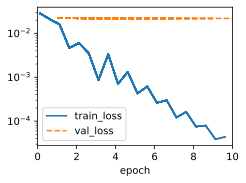

In [6]:
train_scratch(0)

Using Weight Decay

L2 norm of w: 0.0017270983662456274


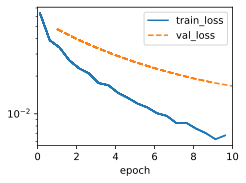

In [7]:
train_scratch(3)

Concise Implementation

In [8]:
class WeightDecay(d2l.LinearRegression):
    def __init__(self, wd, lr):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd

    def configure_optimizers(self):
        return torch.optim.SGD([
            {'params': self.net.weight, 'weight_decay': self.wd},
            {'params': self.net.bias}], lr=self.lr)

The plot looks similar to that when
we implemented weight decay from scratch

L2 norm of w: 0.013779522851109505


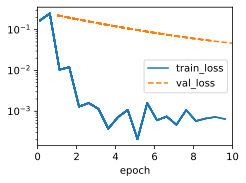

In [9]:
model = WeightDecay(wd=3, lr=0.01)
model.board.yscale='log'
trainer.fit(model, data)

print('L2 norm of w:', float(l2_penalty(model.get_w_b()[0])))